In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.utils import check_random_state
from ForestDiffusion import ForestDiffusionModel
from utrees import UnmaskingTrees

In [2]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical)
my_data = load_iris()
X, y = my_data['data'], my_data['target']
Xy = np.concatenate((X, np.expand_dims(y, axis=1)), axis=1)
palette = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'} 
alpha = 0.6

In [3]:
forest_model = ForestDiffusionModel(
    X, label_y=y, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
Xy_gen_forest = forest_model.generate(batch_size=X.shape[0]) # last variable will be the label_y

ut_model = UnmaskingTrees()
ut_model.fit(Xy, quantize_cols=['continuous']*4 + ['categorical'])
Xy_gen_utrees = ut_model.generate(n_generate=X.shape[0]);

In [4]:
X_mcar = X.copy()
rix = 0
rng = check_random_state(rix)
hasmissing = rng.normal(size=(150,)) < 0.
X_hasmissing = X_mcar[hasmissing, :]
X_hasmissing[rng.normal(size=X_hasmissing.shape) < 0] = np.nan
X_mcar[hasmissing, :] = X_hasmissing
Xy_mcar = np.concatenate((X_mcar, np.expand_dims(y, axis=1)), axis=1)
np.isnan(X_mcar).sum()

151

In [5]:
fdmodel = ForestDiffusionModel(
    X=Xy_mcar,
    n_t=50, duplicate_K=100, diffusion_type='vp',
    bin_indexes=[], cat_indexes=[], int_indexes=[], n_jobs=-1)

Xy_impute_forest_fast = fdmodel.impute(k=1) # regular (fast)
Xy_impute_forest = fdmodel.impute(repaint=True, r=10, j=5, k=1) # REPAINT (slow, but better)

utmodel = UnmaskingTrees()
utmodel.fit(Xy_mcar, quantize_cols=['continuous']*4 + ['categorical'])

Xy_impute_utrees = utmodel.impute(n_impute=1)[0, :, :]

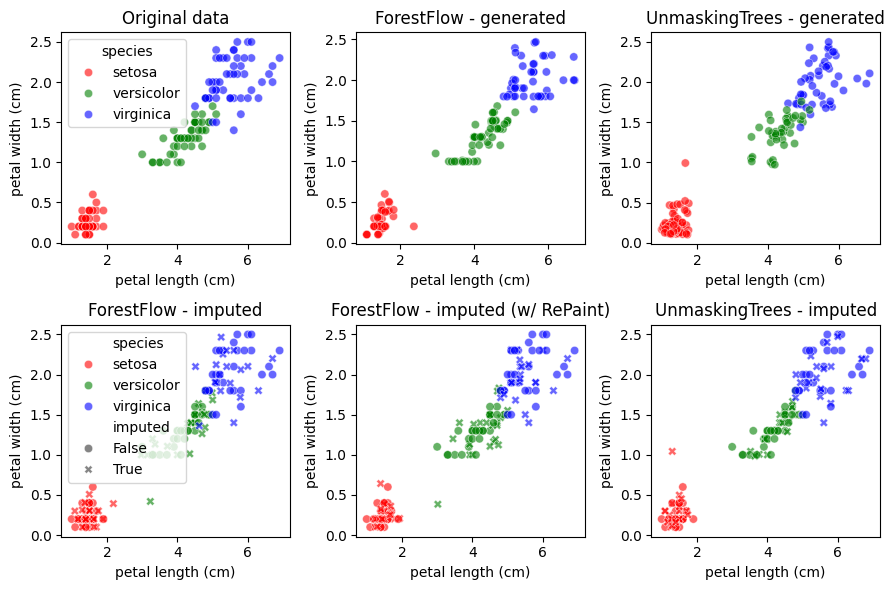

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), squeeze=False);

Xy_df = pd.DataFrame(data=Xy, columns=my_data['feature_names']+['target_names'])
Xy_df['species'] = Xy_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_df, x='petal length (cm)', y='petal width (cm)', hue='species',
    palette=palette, alpha=alpha, ax=axes[0, 0])
axes[0, 0].set_title('Original data');

Xy_gen_forest_df = pd.DataFrame(data=Xy_gen_forest, columns=my_data['feature_names']+['target_names'])
Xy_gen_forest_df['species'] = Xy_gen_forest_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_forest_df, x='petal length (cm)', y='petal width (cm)', hue='species',
    palette=palette, alpha=alpha, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('ForestFlow - generated');

Xy_gen_utrees_df = pd.DataFrame(data=Xy_gen_utrees, columns=my_data['feature_names']+['target_names'])
Xy_gen_utrees_df['species'] = Xy_gen_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='species',
    palette=palette, alpha=alpha, ax=axes[0, 2], legend=False)
axes[0, 2].set_title('UnmaskingTrees - generated');

Xy_impute_forest_fast_df = pd.DataFrame(data=Xy_impute_forest_fast, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_fast_df['species'] = Xy_impute_forest_fast_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_fast_df['imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_fast_df, x='petal length (cm)', y='petal width (cm)', hue='species', style='imputed',
    palette=palette, alpha=alpha, ax=axes[1, 0])
axes[1, 0].set_title('ForestFlow - imputed');

Xy_impute_forest_df = pd.DataFrame(data=Xy_impute_forest, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_df['species'] = Xy_impute_forest_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_df['imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_df, x='petal length (cm)', y='petal width (cm)', hue='species', style='imputed',
    palette=palette, alpha=alpha, ax=axes[1, 1], legend=False)
axes[1, 1].set_title('ForestFlow - imputed (w/ RePaint)');

Xy_impute_utrees_df = pd.DataFrame(data=Xy_impute_utrees, columns=my_data['feature_names']+['target_names'])
Xy_impute_utrees_df['species'] = Xy_impute_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_utrees_df['imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='species', style='imputed',
    palette=palette, alpha=alpha, ax=axes[1, 2], legend=False)
axes[1, 2].set_title('UnmaskingTrees - imputed');

plt.tight_layout();
plt.savefig('iris-demo.png');